In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [95]:
df = pd.read_csv("data\consumption_temp.csv")
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

8641 8641 8641 8641 8641
datetime64[ns]


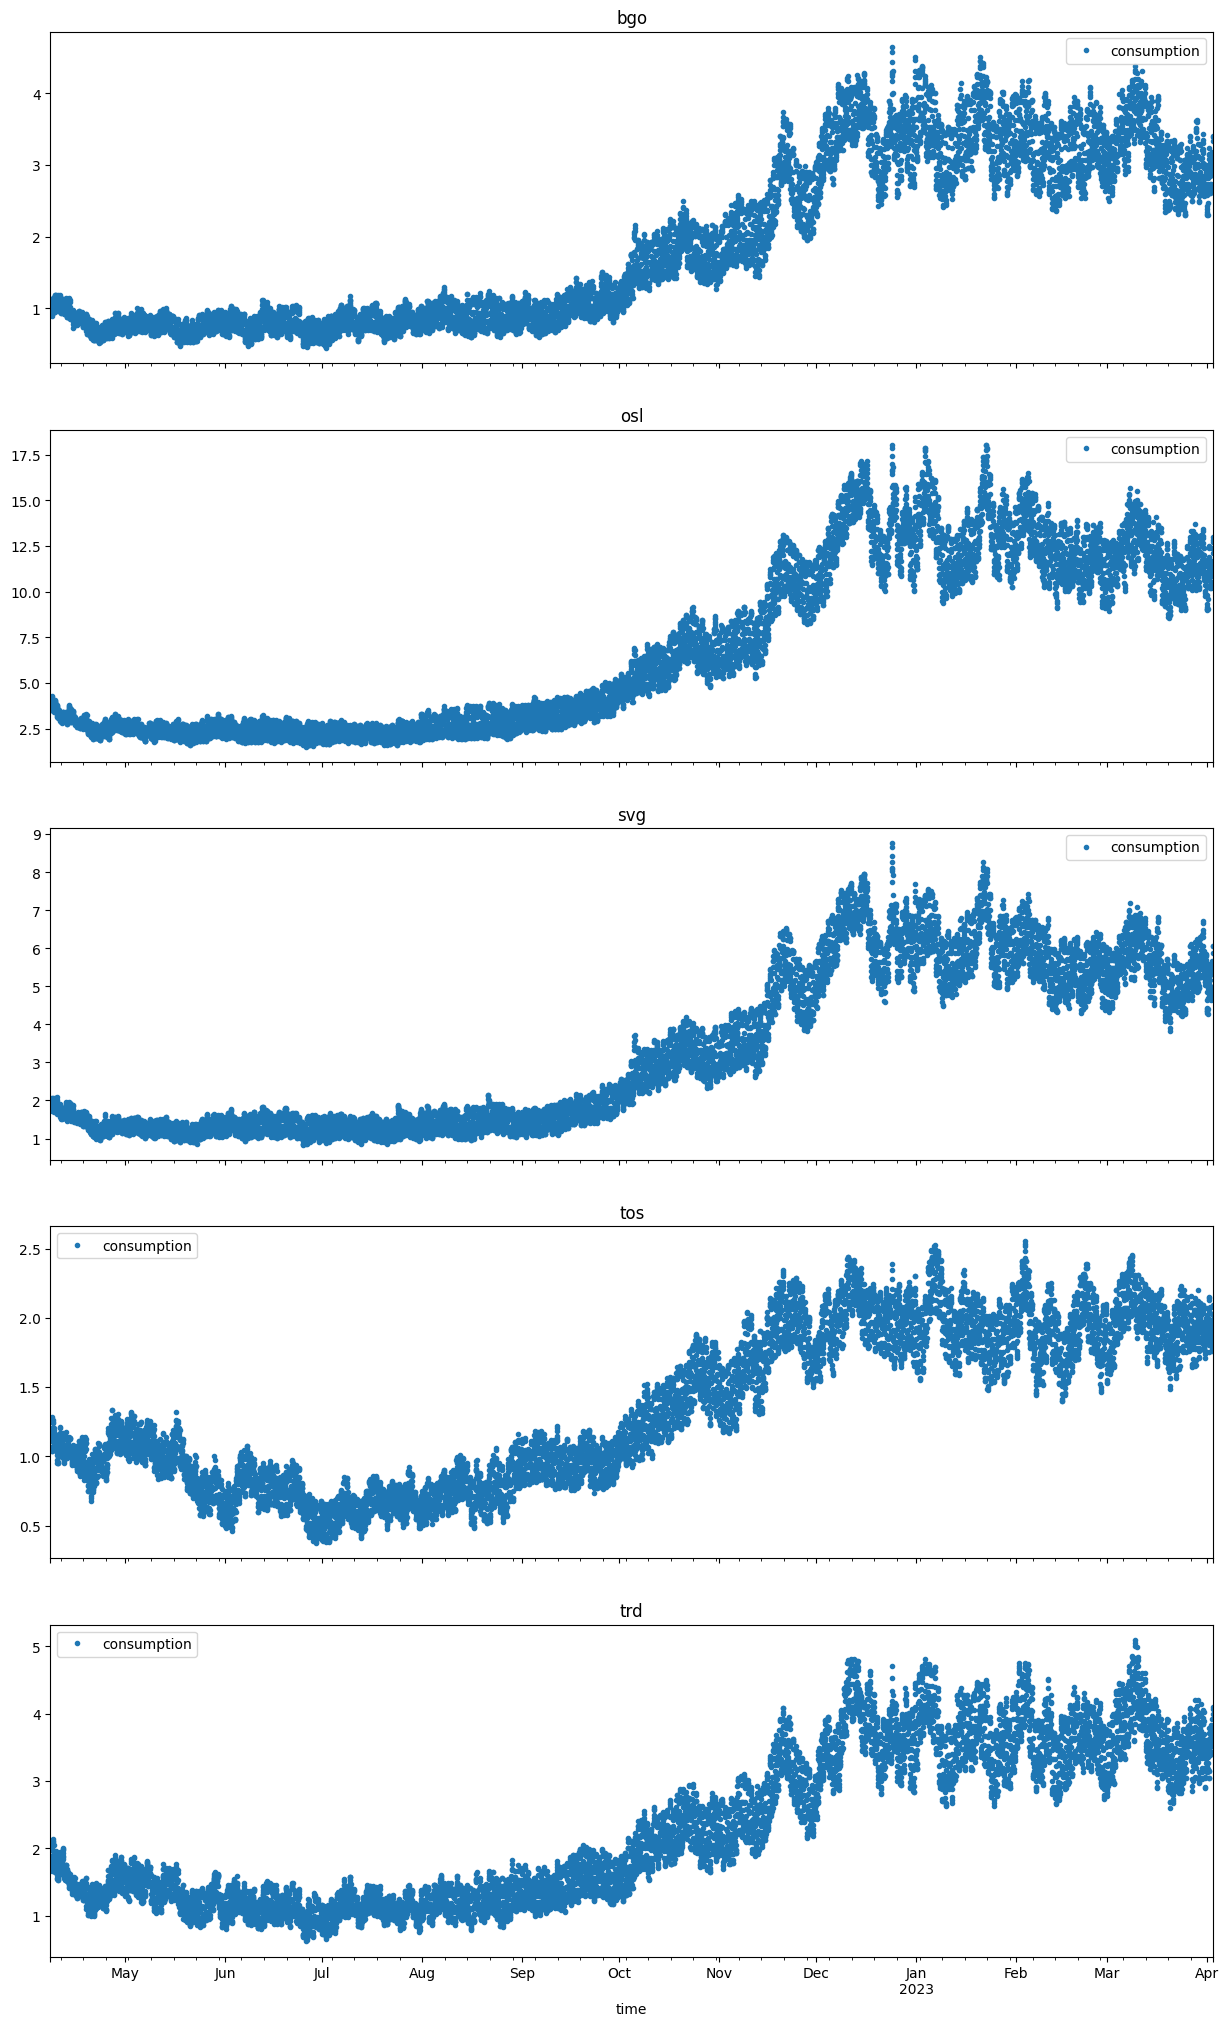

In [96]:
bgo = df.query('location == "bergen"')
osl = df.query('location == "oslo"')
svg = df.query('location == "stavanger"')
tos = df.query('location == "tromsø"')
trd = df.query('location == "trondheim"')

locations = [bgo, osl, svg, tos, trd]

fig, axs = plt.subplots(5, 1, figsize=(15,25), sharex=True)
bgo[["consumption"]].plot(ax=axs[0], title="bgo", style=".")
osl[["consumption"]].plot(ax=axs[1], title="osl", style=".")
svg[["consumption", ]].plot(ax=axs[2], title="svg", style=".")
tos[["consumption", ]].plot(ax=axs[3], title="tos", style=".")
trd[["consumption", ]].plot(ax=axs[4], title="trd", style=".")

print(bgo.shape[0], osl.shape[0], svg.shape[0], tos.shape[0], trd.shape[0])
print(osl.index.dtype)


## Simple train/test split

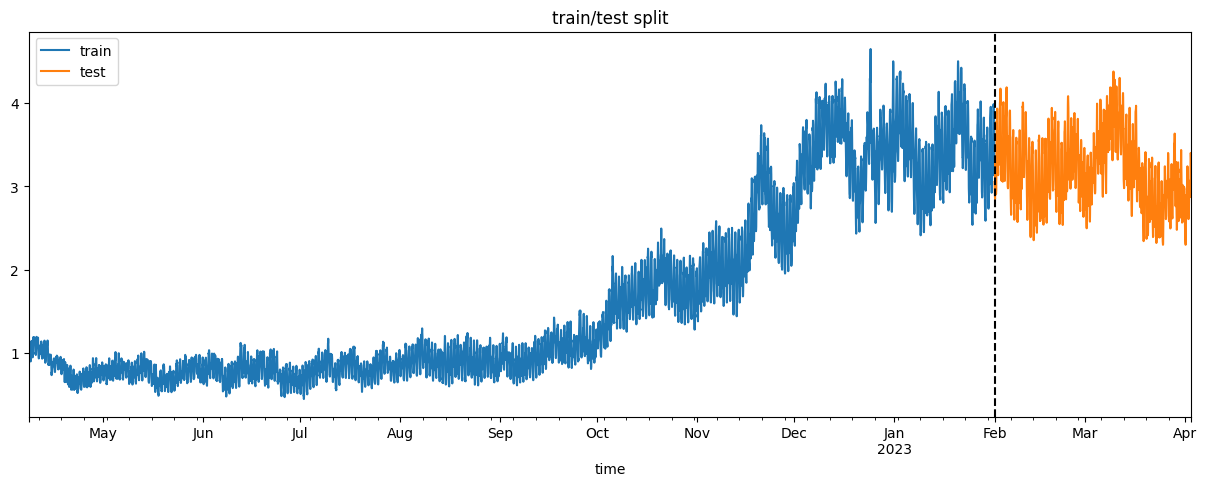

In [97]:
train = bgo.loc[bgo.index < "02-2023"]
test = bgo.loc[bgo.index >= "02-2023"]

fig, ax = plt.subplots(figsize=(15,5))
train["consumption"].plot(ax=ax, label="train", title="train/test split")
test["consumption"].plot(ax=ax, label="test")
ax.axvline("02-2023", color="black", ls="--")
ax.legend(["train", "test"])
plt.show()

<Axes: title={'center': 'One week of data'}, xlabel='time'>

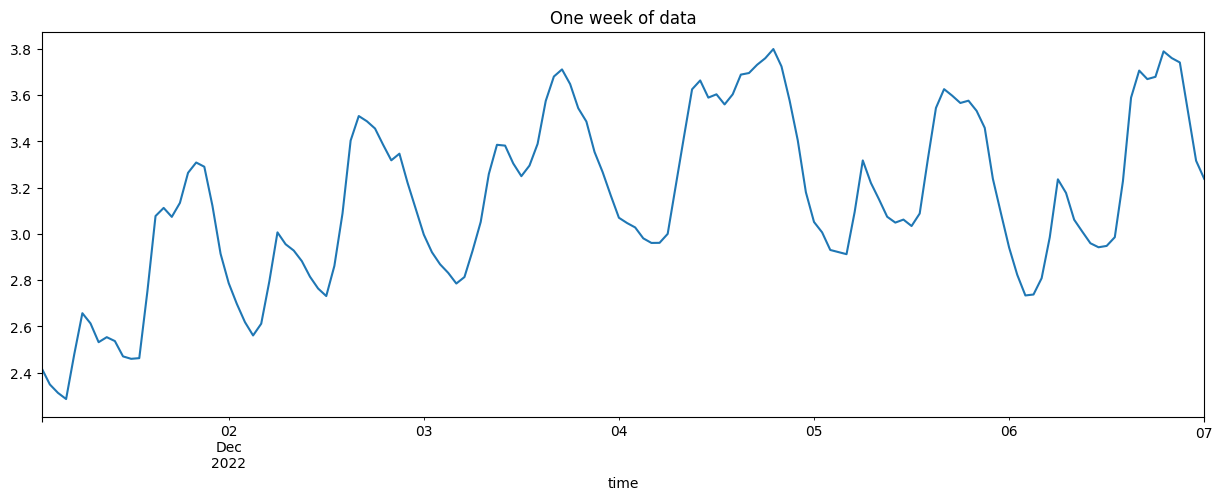

In [98]:
bgo.loc[(bgo.index > "12-01-2022") & (bgo.index <= "12-07-2022")]["consumption"].plot(
    figsize=(15,5), title="One week of data"
)

## Model Creation

In [99]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [100]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'temperature']
TARGET = 'consumption'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [101]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1.53301	validation_1-rmse:2.68805


[100]	validation_0-rmse:0.64951	validation_1-rmse:1.32760
[200]	validation_0-rmse:0.31843	validation_1-rmse:0.73446
[300]	validation_0-rmse:0.20143	validation_1-rmse:0.59881
[400]	validation_0-rmse:0.16084	validation_1-rmse:0.56121
[500]	validation_0-rmse:0.14313	validation_1-rmse:0.54900
[600]	validation_0-rmse:0.13467	validation_1-rmse:0.54257
[700]	validation_0-rmse:0.12796	validation_1-rmse:0.53749
[800]	validation_0-rmse:0.12248	validation_1-rmse:0.53350
[900]	validation_0-rmse:0.11834	validation_1-rmse:0.53101
[999]	validation_0-rmse:0.11501	validation_1-rmse:0.52888


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

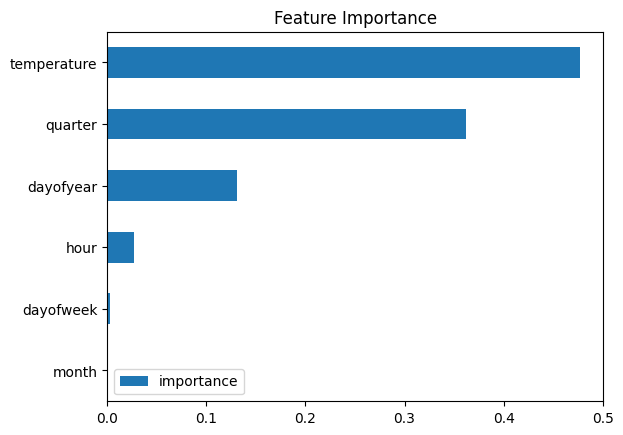

In [102]:

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

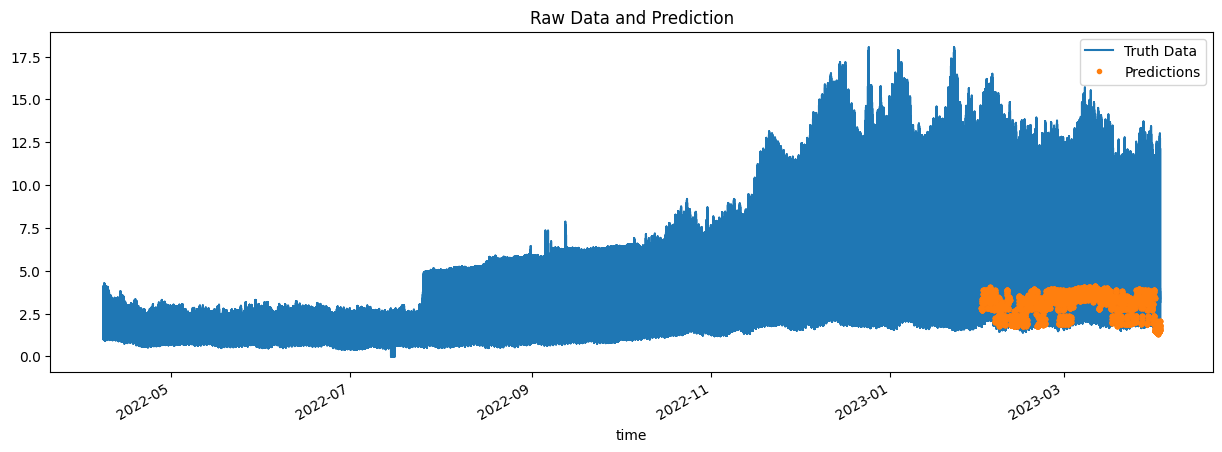

In [103]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['consumption']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

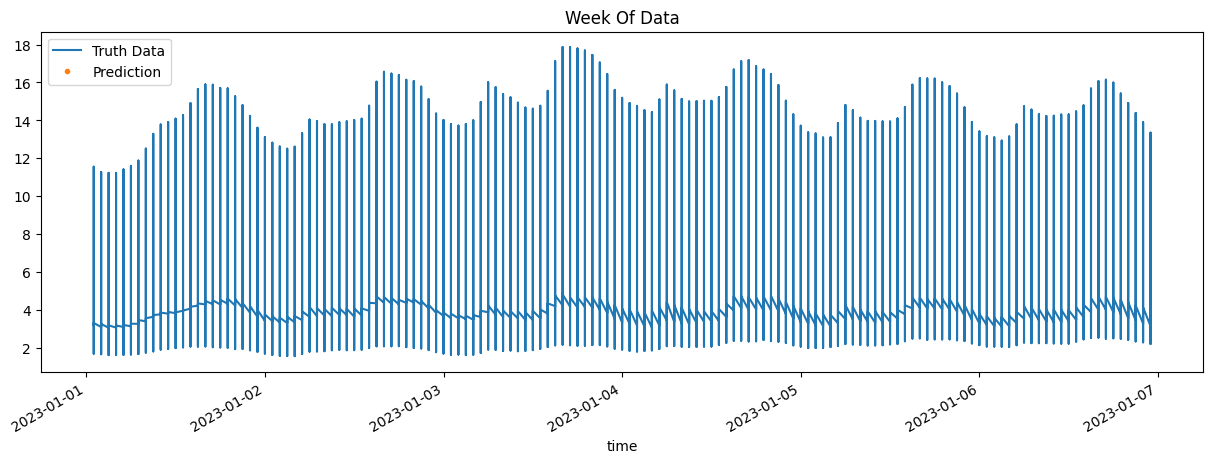

In [104]:
ax = df.loc[(df.index > '01-01-2023') & (df.index < '01-07-2023')]['consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2023') & (df.index < '01-07-2022')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [105]:
score = np.sqrt(mean_squared_error(test['consumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.53


In [106]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-04-02    1.417540
2023-04-01    1.204746
2023-02-11    1.004098
2023-02-12    0.926121
2023-02-15    0.800734
2023-02-08    0.746221
2023-03-25    0.632520
2023-03-19    0.610895
2023-02-10    0.610316
2023-02-20    0.552558
Name: error, dtype: float64